In [1]:
# Dependencies
import pandas as pd
import numpy as np

# Modeling and scores
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score

# Plotting and Preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import datetime as dt
from datetime import timedelta
from sktime.utils.plotting import plot_series
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# Linear Models and Ensemble Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor


Load In Data Set

In [2]:
hotel_agg = pd.read_csv('aggregated_hotel_demand.csv').drop(columns= 'Unnamed: 0')

Error Metrics Dataframe for Models

In [3]:
# Create metric function for RMSE, MAPE, WMAPE
def error_metrics(actual, predicted, model_name):
    """
    ## actual: y_true
    ## predicted: y_pred
    ## model_name: model used
    """
    rmse_val = root_mean_squared_error(actual, predicted)
    mape_val = mean_absolute_percentage_error(actual, predicted)
    wmape_val = np.sum(np.abs(actual - predicted)) / np.sum(actual)

    return(pd.DataFrame({'model':[model_name],
                         'rmse':[rmse_val],
                         'mape': [mape_val],
                         'wmape': [wmape_val]}))

# Preprocessing

## Correlation With Averaged Variables

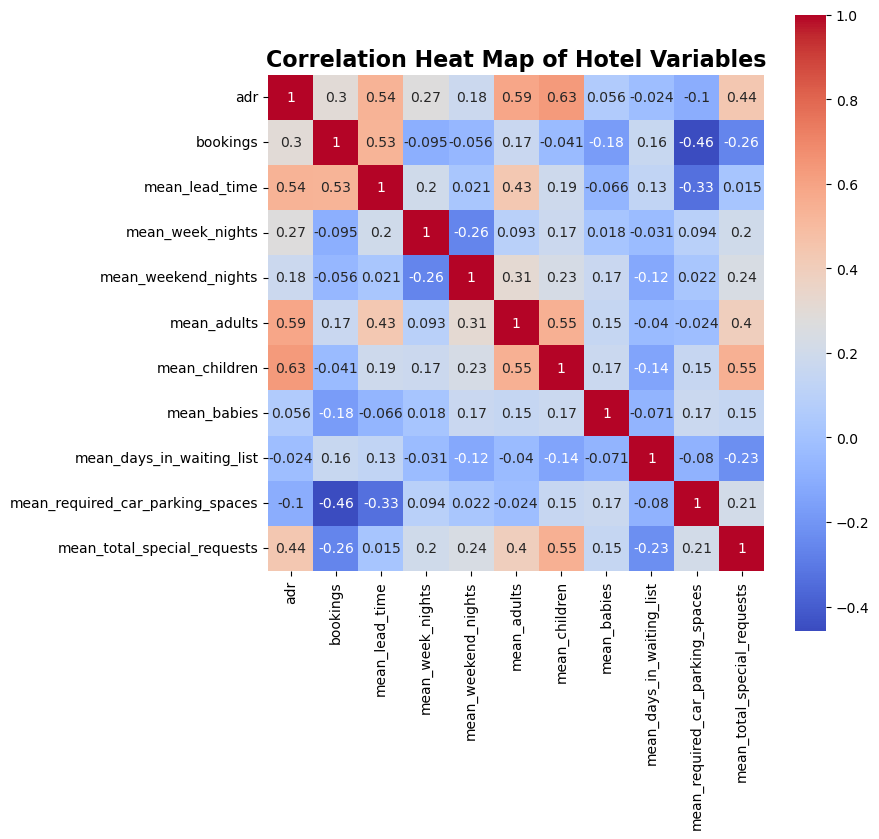

In [4]:
hotel_corr_avg = hotel_agg[['adr', 'bookings','mean_lead_time', 'mean_week_nights', 
           'mean_weekend_nights', 'mean_adults', 'mean_children', 
           'mean_babies', 'mean_days_in_waiting_list', 
           'mean_required_car_parking_spaces', 'mean_total_special_requests']].corr()

ax = plt.figure(figsize= (8,8))
sns.heatmap(hotel_corr_avg, cmap= 'coolwarm', annot =True, square= True)
plt.title('Correlation Heat Map of Hotel Variables', fontdict = {'fontweight':'bold', 'fontsize': 16})
plt.show()

In [5]:
# Most significant correlation with demand:
important_columns_1 = hotel_corr_avg[['bookings']].sort_values( by = 'bookings',key= abs, ascending= False).query('abs(bookings) >=0.15').index
hotel_corr_avg[['bookings']].sort_values( by = 'bookings',key= abs, ascending= False).query('abs(bookings) >=0.15')

,bookings
bookings,1.000000
mean_lead_time,0.529648
mean_required_car_parking_spaces,-0.457250
adr,0.296921
mean_total_special_requests,-0.259862
mean_babies,-0.177304
mean_adults,0.167166
mean_days_in_waiting_list,0.161465


## Correlation with Aggregated Variables

In [6]:
hotel_corr_agg = hotel_agg[['bookings', 'meal_BB_proportion',
       'meal_FB_proportion', 'meal_HB_proportion', 'meal_SC_proportion',
       'meal_undefined_proportion', 'meal_nan_proportion',
       'market_Aviation_proportion', 'market_Complementary_proportion',
       'market_Corporate_proportion', 'market_Direct_proportion',
       'market_Groups_proportion', 'market_Offline_TA_TO_proportion',
       'market_Online_TA_proportion', 'market_Undefined_proportion',
       'market_nan_proportion', 'deposit_No_Deposit_proportion',
       'deposit_Non_Refund_proportion', 'deposit_Refundable_proportion',
       'deposit_nan_proportion', 'customer_Contract_proportion',
       'customer_Group_proportion', 'customer_Transient_proportion',
       'customer_Transient_Party_proportion', 'customer_nan_proportion',
       'room_moved_proportion', 'room_not_moved_proportion',
       'room_nan_proportion', 'hotel_City_proportion',
       'hotel_Resort_proportion', 'hotel_nan_proportion',
       'assigned_A_proportion', 'assigned_B_proportion',
       'assigned_C_proportion', 'assigned_D_proportion',
       'assigned_E_proportion', 'assigned_F_proportion',
       'assigned_G_proportion', 'assigned_H_proportion',
       'assigned_I_proportion', 'assigned_K_proportion',
       'assigned_L_proportion', 'assigned_nan_proportion']].corr()

Most significant columns

In [7]:
important_cols_2 = hotel_corr_agg[['bookings']].sort_values(by = 'bookings', key= abs, ascending= False).query('abs(bookings) >=0.15').index
hotel_corr_agg[['bookings']].sort_values(by = 'bookings', key= abs, ascending= False).query('abs(bookings) >=0.15')

,bookings
bookings,1.000000
market_Direct_proportion,-0.507497
deposit_No_Deposit_proportion,-0.487992
deposit_Non_Refund_proportion,0.483653
assigned_A_proportion,0.465651
hotel_City_proportion,0.458626
hotel_Resort_proportion,-0.458626
assigned_D_proportion,-0.439876
room_not_moved_proportion,0.394406
room_moved_proportion,-0.394406


In [8]:
model_cols = important_columns_1.union(important_cols_2)

## Seasonal Encoding
- May help control confounding factors

### Day of week & Month

In [9]:
# Create Dummy Variables for month and day of week
hotel_agg = pd.get_dummies(data= hotel_agg, columns= ['arrival_date_month', 'arrival_day_of_week'])

In [10]:
# Define Seasonal One hot encoded columns
seasonal_cols = hotel_agg[['arrival_date_month_April', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September',
       'arrival_day_of_week_Friday', 'arrival_day_of_week_Monday',
       'arrival_day_of_week_Saturday', 'arrival_day_of_week_Sunday',
       'arrival_day_of_week_Thursday', 'arrival_day_of_week_Tuesday',
       'arrival_day_of_week_Wednesday']].columns

# Combine seasonal dummy cols with quantitative columns
confounding_model_cols = model_cols.union(seasonal_cols)

### Holiday Encoding

From Chat gpt: dates are not all correct

| Rank  | Holiday                                                        | Typical Dates        | Why It Matters                                                                        |
| ----- | -------------------------------------------------------------- | -------------------- | ------------------------------------------------------------------------------------- |
| **1** | **Easter Weekend** (Good Friday, Easter Sunday, Easter Monday) | March–April (varies) | Major long weekend; strong leisure travel; widely observed across Europe              |
| **2** | **Christmas (Eve & Day)**                                      | Dec 24–25            | Peak family travel and winter holiday period; huge impact on ADR and occupancy        |
| **3** | **New Year’s (Eve & Day)**                                     | Dec 31 & Jan 1       | Urban stays, parties, events; high ADRs; strong booking patterns                      |
| **4** | **Labor Day / May Day**                                        | May 1                | Pan-European holiday; long weekend leisure travel; often bridges with Ascension       |
|

We want 
- easter weekend (good friday, easter sunday)
- Christmas Eve and day
- New years eve and day
- Labor/May day

#### Scraping Holiday Dates

In [11]:
hol_df = pd.DataFrame({'date': [],
              'Holiday': []})

date_list = []
hol_list = []


for hol in holidays.PT(years = [2015,2016, 2017]).items():
    date_list.append(hol[0])
    hol_list.append(hol[1])

hol_df['date'] = date_list
hol_df['Holiday'] = hol_list

hol_df = hol_df[(hol_df['Holiday'].str.contains('New')) | (hol_df['Holiday'].str.contains('Christmas'))|
       (hol_df['Holiday'].str.contains('Labor'))| (hol_df['Holiday'].str.contains('Good'))|
       (hol_df['Holiday'].str.contains('Easter'))]
print(hol_df['Holiday'].unique())

hol_df['date_upper_bound'] = hol_df['date'] + timedelta(days=3)
hol_df['date_upper_bound'] = pd.to_datetime(hol_df['date_upper_bound']
                                            )
hol_df['date_lower_bound'] = hol_df['date'] - timedelta(days=3)
hol_df['date_lower_bound'] = pd.to_datetime(hol_df['date_lower_bound'] )

["New Year's Day" 'Good Friday' 'Easter Sunday' 'Labor Day'
 'Christmas Day']


#### Making Holiday a feature

In [12]:
# Convert arrival date to datetime
hotel_agg['arrival_date'] = pd.to_datetime(hotel_agg['arrival_date'])


arr = hotel_agg['arrival_date'].values
lb = hol_df['date_lower_bound'].values
ub = hol_df['date_upper_bound'].values

mask = (
    (arr[:, None] >= lb[None, :]) &   # N x M
    (arr[:, None] <= ub[None, :])     # N x M
).any(axis=1)                         # reduce over holidays → length N

hotel_agg['is_holiday'] = np.where(mask, 1, 0)


In [13]:
hotel_agg['is_holiday'].sum()

np.int64(60)

<Axes: xlabel='adr', ylabel='bookings'>

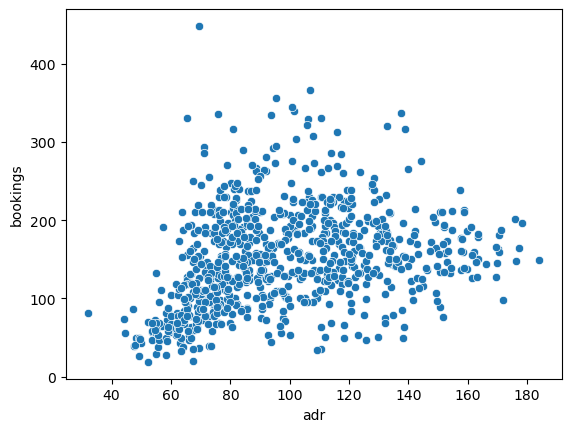

In [14]:
sns.scatterplot(hotel_agg, x ='adr', y ='bookings')

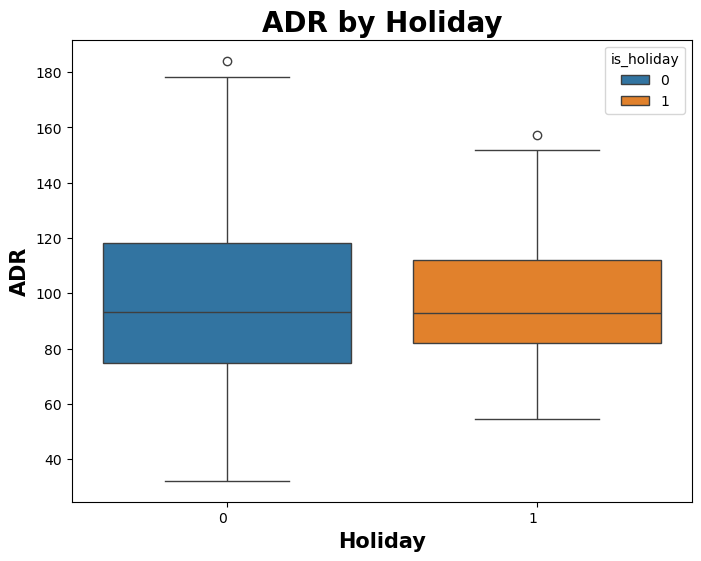

In [15]:
plt.figure(figsize=( 8,6))

ax = sns.boxplot(data = hotel_agg, 
            x = 'is_holiday', 
            y ='adr', 
            hue = 'is_holiday')

plt.title('ADR by Holiday', fontdict = {'fontweight':'bold', 'fontsize': 20})


# X axis
plt.xlabel(xlabel= 'Holiday',fontdict = {'fontweight':'bold', 'fontsize': 15})
plt.xticks(rotation = 0, ha = 'right', fontweight = 'normal') # Rotate x tick labels to make plot more readable
# Y axis
plt.ylabel(ylabel= 'ADR', fontdict ={'fontweight': 'bold', 'fontsize': 15})
plt.show() # THis hides x tick labels from printing 

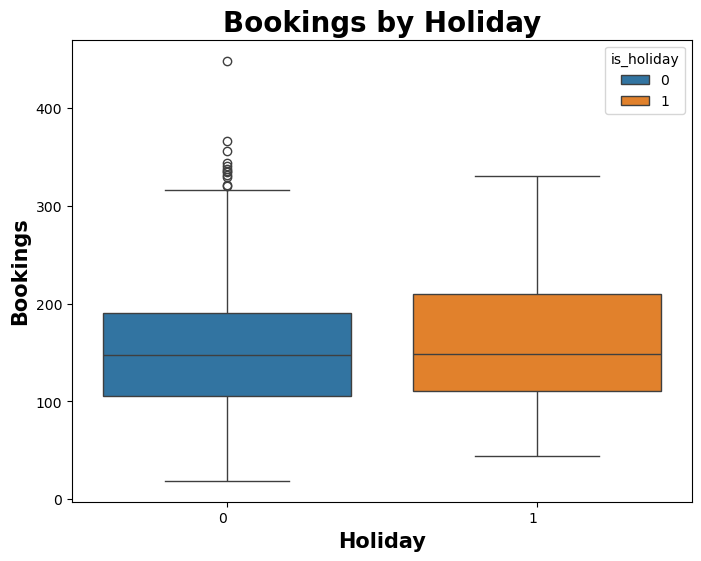

In [16]:
plt.figure(figsize=( 8,6))

ax = sns.boxplot(data = hotel_agg, 
            x = 'is_holiday', 
            y ='bookings', 
            hue = 'is_holiday')

plt.title('Bookings by Holiday', fontdict = {'fontweight':'bold', 'fontsize': 20})


# X axis
plt.xlabel(xlabel= 'Holiday',fontdict = {'fontweight':'bold', 'fontsize': 15})
plt.xticks(rotation = 0, ha = 'right', fontweight = 'normal') # Rotate x tick labels to make plot more readable
# Y axis
plt.ylabel(ylabel= 'Bookings', fontdict ={'fontweight': 'bold', 'fontsize': 15})
plt.show() # THis hides x tick labels from printing 

In [17]:
hotel_agg[hotel_agg['is_holiday'] == 0]['bookings'].mean()

np.float64(149.9181446111869)

In [18]:
hol_cols= hotel_agg[['is_holiday']].columns
holiday_model_cols = confounding_model_cols.union(hol_cols)

In [19]:
modeling_df = hotel_agg[model_cols]
confounder_modeling_df = hotel_agg[confounding_model_cols]
holiday_model_df = hotel_agg[holiday_model_cols]

## Dataset splitting for modeling

Exporting Dataset to share with group

In [20]:
#holiday_model_df.to_csv('modeling_df.csv')

Split Data

Non-confounding control split

In [21]:
X = modeling_df.drop(columns= 'bookings')
y = modeling_df['bookings']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= 0.2)

Confounder Control split

In [22]:
X = confounder_modeling_df.drop(columns= 'bookings')
y = confounder_modeling_df['bookings']

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X, y, random_state= 42, test_size= 0.2)

Holiday Control split

In [23]:
X = holiday_model_df.drop(columns= 'bookings')
y = holiday_model_df['bookings']

x_train_h, x_test_h, y_train_h, y_test_h = train_test_split(X, y, random_state= 42, test_size= 0.2)

# Linear model

## No Confounder Control
- Most Likely overfit

In [24]:
lm = LinearRegression()

lm.fit(x_train, y_train)

print(lm.score(x_train, y_train))

print(lm.score(x_test, y_test))

pd.DataFrame({'col': lm.feature_names_in_,
              'coef': lm.coef_}
).head(1)

0.6492403487111945
0.49872877448262865


,col,coef
0,adr,0.313269


In [25]:
error_metrics(lm.predict(x_test), y_test, 'simple linear (confounding)')

,model,rmse,mape,wmape
0,simple linear (confounding),45.420883,0.223008,0.221552


## Confounder Control

In [26]:
lm = LinearRegression()

lm.fit(x_train_c, y_train_c)

print(lm.score(x_train_c, y_train_c))

print(lm.score(x_test_c, y_test_c))

pd.DataFrame({'col': lm.feature_names_in_,
              'coef': lm.coef_}
).head(1)

0.7124747446398292
0.6304354302932358


,col,coef
0,adr,0.720118


In [27]:
error_metrics(lm.predict(x_test_c), y_test_c, 'simple linear (confounder control)')

,model,rmse,mape,wmape
0,simple linear (confounder control),38.999976,0.19309,0.18976


## Holiday Control

In [28]:
lm = LinearRegression()

lm.fit(x_train_h, y_train_h)

print(lm.score(x_train_h, y_train_h))

print(lm.score(x_test_h, y_test_h))

pd.DataFrame({'col': lm.feature_names_in_,
              'coef': lm.coef_}
).head(1)

0.7140652069224755
0.635591504459798


,col,coef
0,adr,0.675089


In [29]:
lm_holiday = error_metrics(lm.predict(x_test_h), y_test_h, 'simple linear (Holiday control)')
lm_holiday

,model,rmse,mape,wmape
0,simple linear (Holiday control),38.726962,0.192049,0.188276


Best Linear model (has holiday control):
- RMSE of 38.7
- MAPE 0.192
- WMAPE 0.1882


## Grid Search LM

In [30]:
lm_param_grid = {'fit_intercept': [True, False]}

lm_gs = GridSearchCV(estimator= LinearRegression(),
                     param_grid= lm_param_grid,
                      cv=  KFold(n_splits= 5, shuffle= True, random_state= 42))

lm_gs.fit(x_train_h, y_train_h)

lm_gs_results = pd.DataFrame(lm_gs.cv_results_)
lm_gs_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004450,0.002884,0.001945,0.000267,True,{'fit_intercept': True},0.677918,0.613361,0.685215,0.655364,0.65856,0.658083,0.025049,1
1,0.002997,0.000298,0.001713,0.000118,False,{'fit_intercept': False},0.677918,0.613361,0.685215,0.655364,0.65856,0.658083,0.025049,2


In [31]:
error_metrics(lm_gs.predict(x_test_h), y_test_h, 'gs simple linear (Holiday control)')

,model,rmse,mape,wmape
0,gs simple linear (Holiday control),38.726962,0.192049,0.188276


# Lasso

## No Confounder Control

In [32]:
lasso = Lasso(alpha= 0.1)

lasso.fit(x_train, y_train)

print(lasso.score(x_train, y_train))

print(lasso.score(x_test, y_test))

pd.DataFrame({'col': lasso.feature_names_in_,
              'coef': lasso.coef_}
).head(1)

error_metrics(lasso.predict(x_test), y_test, 'lasso (confounding)')

0.640993800130385
0.5043976084726265


,model,rmse,mape,wmape
0,lasso (confounding),45.163322,0.221902,0.221473


## Confounder Control

In [33]:
lasso = Lasso(alpha= 0.1)

lasso.fit(x_train_c, y_train_c)

print(lasso.score(x_train_c, y_train_c))

print(lasso.score(x_test_c, y_test_c))

pd.DataFrame({'col': lasso.feature_names_in_,
              'coef': lasso.coef_}
).head(1)

error_metrics(lasso.predict(x_test_c), y_test_c, 'lasso (confounder control)')

0.7055461740467608
0.6414490212528682


,model,rmse,mape,wmape
0,lasso (confounder control),38.414452,0.185577,0.187766


## Holiday Control

In [34]:
lasso = Lasso(alpha= 0.1)

lasso.fit(x_train_h, y_train_h)

print(lasso.score(x_train_h, y_train_h))

print(lasso.score(x_test_h, y_test_h))

pd.DataFrame({'col': lasso.feature_names_in_,
              'coef': lasso.coef_}
).head(1)



0.707498935141996
0.6450452266606282


,col,coef
0,adr,0.713655


In [35]:
lasso_holiday = error_metrics(lasso.predict(x_test_h), y_test_h, 'lasso (holiday control)')
lasso_holiday

,model,rmse,mape,wmape
0,lasso (holiday control),38.221321,0.183621,0.18601


Best Lasso model:
- RMSE 38.22
- MAPE 0.184
- WMAPE 0.186

### Best Lasso Model Features

In [36]:
# Create df of cols and associated coefs
lasso_features = pd.DataFrame(lasso.feature_names_in_,
lasso.coef_).reset_index().rename(columns= {'index': 'coef',
                                            0: 'col'})

# Features that were shrunk to 0
shrunk = lasso_features.query('abs(coef) ==0.0').sort_values(by = 'coef', ascending= False)
print(shrunk.shape)

# Features that were not shrunk to 0
not_shrunk = lasso_features.query('abs(coef) >0.0').sort_values(by = 'coef', ascending= False)
print(not_shrunk.shape)
print(x_train_h.T.shape)

(18, 2)
(30, 2)
(48, 634)


In [37]:
not_shrunk[not_shrunk['col'].str.contains('hotel')]

,coef,col
29,2.464799e+01,hotel_City_proportion
30,-1.065593e-15,hotel_Resort_proportion


In [38]:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
not_shrunk

,coef,col
25,74.50,customer_Transient_Party_proportion
20,71.38,assigned_A_proportion
29,24.65,hotel_City_proportion
35,18.31,market_Groups_proportion
11,15.38,arrival_date_month_October
8,14.84,arrival_date_month_March
9,13.29,arrival_date_month_May
1,10.85,arrival_date_month_April
31,10.42,is_holiday
4,6.71,arrival_date_month_February


Features shrunk to 0

In [39]:
shrunk

,coef,col
10,0.00,arrival_date_month_November
12,-0.00,arrival_date_month_September
15,0.00,arrival_day_of_week_Saturday
17,0.00,arrival_day_of_week_Thursday
21,-0.00,assigned_D_proportion
22,-0.00,assigned_E_proportion
24,-0.00,customer_Group_proportion
26,0.00,customer_Transient_proportion
28,0.00,deposit_Non_Refund_proportion
32,0.00,market_Complementary_proportion


In [40]:
pd.reset_option('display.float_format')

# Random Forest

## No Confounder Control

In [41]:
rf = RandomForestRegressor(n_estimators=100,
                            max_features= 'sqrt',
                            bootstrap= True,
                            oob_score = True,
                            random_state= 42)

rf.fit(x_train, y_train)

print(rf.score(x_train, y_train))

print(rf.score(x_test, y_test))

error_metrics(rf.predict(x_test), y_test, 'Random Forest (confounding)')

0.9464257437184771
0.5487036546467665


,model,rmse,mape,wmape
0,Random Forest (confounding),43.097303,0.206135,0.210355


## Confounder Control

In [42]:
rf = RandomForestRegressor(n_estimators=100,
                            max_features= 'sqrt',
                            bootstrap= True,
                            oob_score = True,
                            random_state= 42)

rf.fit(x_train_c, y_train_c)

print(rf.score(x_train_c, y_train_c))

print(rf.score(x_test_c, y_test_c))

error_metrics(rf.predict(x_test_c), y_test_c, 'Random Forest (confounder control)')

0.946110208001008
0.5910626191700674


,model,rmse,mape,wmape
0,Random Forest (confounder control),41.024905,0.198325,0.203015


## Holiday Control

In [43]:
rf = RandomForestRegressor(n_estimators=100,
                            max_features= 'sqrt',
                            bootstrap= True,
                            oob_score = True,
                            random_state= 42)

rf.fit(x_train_h, y_train_h)

print(rf.score(x_train_h, y_train_h))

print(rf.score(x_test_h, y_test_h))

0.9466993613268956
0.5716131912286794


In [44]:
rf_holiday = error_metrics(rf.predict(x_test_h), y_test_h, 'Random Forest (Holiday control)')
rf_holiday

,model,rmse,mape,wmape
0,Random Forest (Holiday control),41.989164,0.201463,0.205257


Best Random Forest:
- RMSE: 41.98
- MAPE: 0.201
- WMAPE: 0.205

# ADA Boost

## No Confounder Control

In [45]:
# Create Gradient boosting object
ada = AdaBoostRegressor(learning_rate= 0.1,
                        n_estimators= 2000,
                        random_state= 2503) 

# Fit graident model
ada.fit(x_train,y_train)

# x train accuracy
ada_train = ada.score(x_train, y_train)
print(ada_train)

# x test accuracy 
ada_test = ada.score(x_test, y_test)
print(ada_test)

error_metrics(ada.predict(x_test), y_test, 'ADA Boost (confounding)')

0.7250522450128464
0.4768266587156015


,model,rmse,mape,wmape
0,ADA Boost (confounding),46.402565,0.226201,0.224167


## confounder control

In [46]:
# Create Gradient boosting object
ada = AdaBoostRegressor(learning_rate= 0.3,
                        n_estimators= 2000,
                        random_state= 2503) 

# Fit graident model
ada.fit(x_train_c,y_train_c)

# x train accuracy
ada_train = ada.score(x_train_c, y_train_c)
print(ada_train)

# x test accuracy 
ada_test = ada.score(x_test_c, y_test_c)
print(ada_test)

error_metrics(ada.predict(x_test_c), y_test_c, 'ADA Boost (confounder control)')

0.7315279179396064
0.4790054954728631


,model,rmse,mape,wmape
0,ADA Boost (confounder control),46.305838,0.23013,0.226907


## Holiday Control

In [47]:
# Create Gradient boosting object
ada = AdaBoostRegressor(learning_rate= 0.3,
                        n_estimators= 2000,
                        random_state= 2503) 

# Fit graident model
ada.fit(x_train_h,y_train_h)

# x train accuracy
ada_train = ada.score(x_train_h, y_train_h)
print(ada_train)

# x test accuracy 
ada_test = ada.score(x_test_h, y_test_h)
print(ada_test)

0.7288429356907269
0.4794702370615026


In [48]:
#ada_holiday = error_metrics(ada.predict(x_test_h), y_test_h, 'ADA Boost (holiday control)')
#ada_holiday

best ADA model
- RMSE: 46.28
- MAPE: 0.230
- WMAPE: 0.223


# Gradient Boosting

## No confounder control

In [49]:
# Create Gradient boosting object
gb = GradientBoostingRegressor(loss = 'squared_error',
                                      learning_rate= 0.15,
                                      n_estimators= 2000,
                                      max_depth= 1,
                                      random_state= 2503) 

# Fit graident model
gb.fit(x_train,y_train)

# x train accuracy
gb_train = gb.score(x_train, y_train)
print(gb_train)

# x test accuracy 
gb_test = gb.score(x_test, y_test)
print(gb_test)

error_metrics(gb.predict(x_test), y_test, 'Gradient Boosting (confounding)')

0.9057407545300544
0.5984007468379424


,model,rmse,mape,wmape
0,Gradient Boosting (confounding),40.655156,0.204869,0.200493


## Confounder Control

In [50]:
# Create Gradient boosting object
gb = GradientBoostingRegressor(loss = 'squared_error',
                                      learning_rate= 0.15,
                                      n_estimators= 2000,
                                      max_depth= 1,
                                      random_state= 2503) 

# Fit graident model
gb.fit(x_train_c,y_train_c)

# x train accuracy
gb_train = gb.score(x_train_c, y_train_c)
print(gb_train)

# x test accuracy 
gb_test = gb.score(x_test_c, y_test_c)
print(gb_test)

error_metrics(gb.predict(x_test_c), y_test_c, 'Gradient Boosting (confounder control)')

0.9160123719589155
0.6270127473054872


,model,rmse,mape,wmape
0,Gradient Boosting (confounder control),39.180157,0.191326,0.189745


## Holiday Control

In [51]:
# Create Gradient boosting object
gb = GradientBoostingRegressor(loss = 'squared_error',
                                      learning_rate= 0.15,
                                      n_estimators= 2000,
                                      max_depth= 1,
                                      random_state= 2503) 

# Fit graident model
gb.fit(x_train_h,y_train_h)

# x train accuracy
gb_train = gb.score(x_train_h, y_train_h)
print(gb_train)

# x test accuracy 
gb_test = gb.score(x_test_h, y_test_h)
print(gb_test)

error_metrics(gb.predict(x_test_h), y_test_h, 'Gradient Boosting (holiday control)')

0.9160256974899013
0.6293567497194936


,model,rmse,mape,wmape
0,Gradient Boosting (holiday control),39.056851,0.191335,0.189157


In [52]:
# Create Gradient boosting object
gb = GradientBoostingRegressor(loss = 'squared_error',
                                      learning_rate= 0.3,
                                      n_estimators= 300,
                                      max_depth= 3,
                                      min_samples_split= 20,
                                      min_samples_leaf=10,
                                      subsample= 0.8,
                                      random_state= 42) 

# Fit graident model
gb.fit(x_train_h,y_train_h)

# x train accuracy
gb_train = gb.score(x_train_h, y_train_h)
print(gb_train)

# x test accuracy 
gb_test = gb.score(x_test_h, y_test_h)
print(gb_test)

0.9995343416136853
0.592872352441338


In [53]:
gb_holiday = error_metrics(gb.predict(x_test_h), y_test_h, 'Gradient Boosting (holiday control)')
gb_holiday

,model,rmse,mape,wmape
0,Gradient Boosting (holiday control),40.934028,0.196886,0.193587


Best GB Model:
- RMSE: 40.93
- MAPE: 0.1968
- WMAPE: 0.193

# TS Modeling

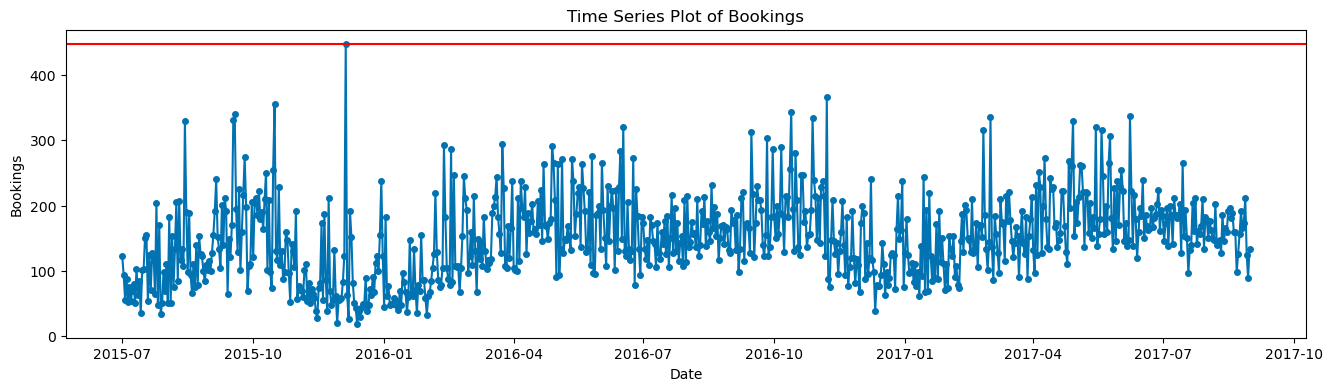

In [54]:
# Select arrival date and bookings col to facilitate time series plot
ts_data = hotel_agg[['arrival_date', 'bookings']]

# Create pandas series from ts_data to use it in sktime plot_series (only accepts series objects)
ts_plot_data = ts_data.set_index('arrival_date')['bookings'].sort_index()

# Plot time series of demand over time
fig, ax = plot_series(ts_plot_data)
ax.set_title('Time Series Plot of Bookings')

ax.set_xlabel('Date')
ax.set_ylabel('Bookings')

plt.axhline(y =hotel_agg['bookings'].max(), color = 'red')
plt.show()

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [56]:
ts_model_data = hotel_agg[['bookings', 'arrival_date']]
ts_model_data['arrival_date'] = pd.to_datetime(ts_model_data['arrival_date'])
ts_model_data = ts_model_data.set_index('arrival_date').sort_index()

# Split Data
x_train_ts = ts_model_data[0:650]
x_test_ts = ts_model_data[650:793]

/tmp/ipykernel_1561038/2211972209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_model_data['arrival_date'] = pd.to_datetime(ts_model_data['arrival_date'])


## PACF

### No differencing

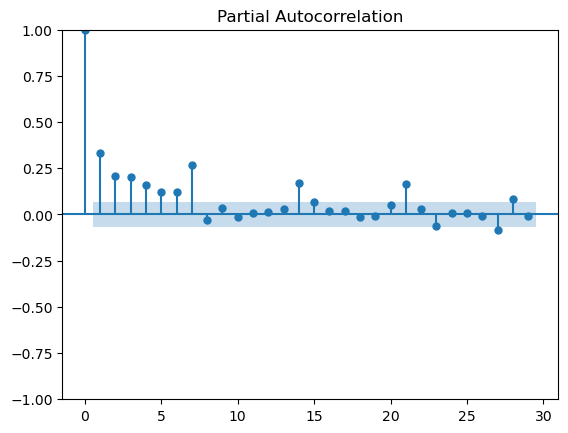

In [57]:
plot_pacf(ts_plot_data)
plt.show()

### dif = 1

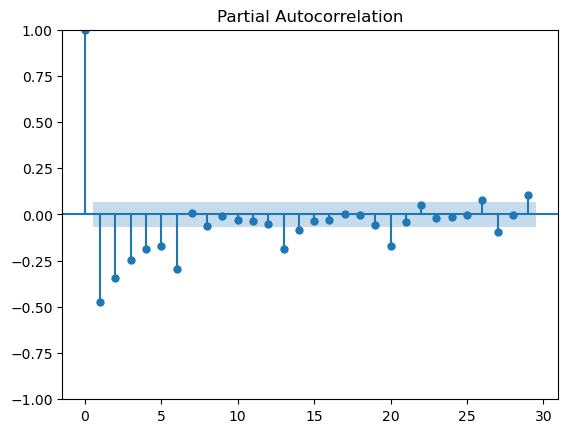

In [58]:
plot_pacf(ts_plot_data.diff(1).dropna())
plt.show()

### dif = 12

### dif = 7

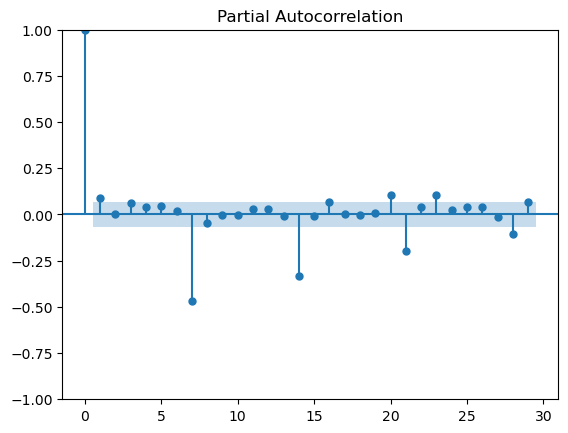

In [59]:
plot_pacf(ts_plot_data.diff(7).dropna())
plt.show()

## ACF

### No differencing

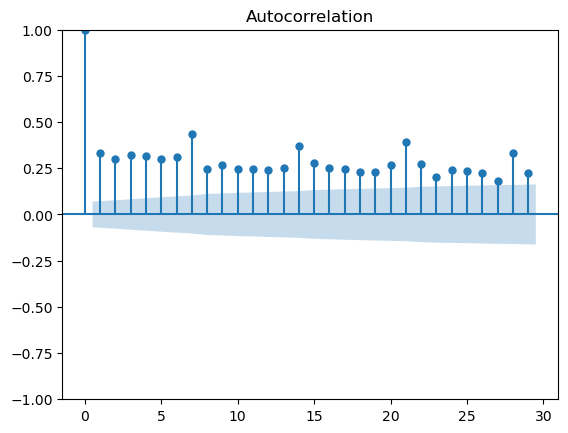

In [60]:
plot_acf(ts_plot_data)
plt.show()

### dif = 1

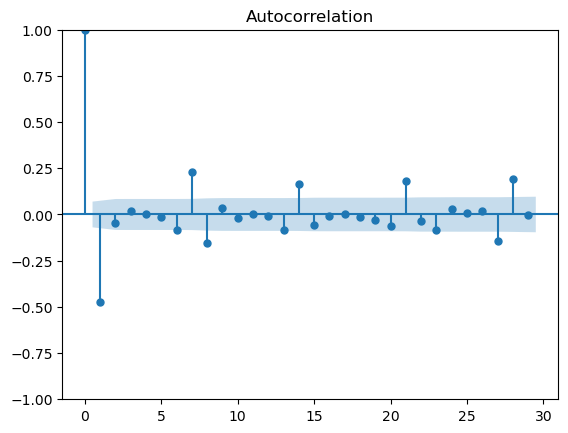

In [61]:
plot_acf(ts_plot_data.diff(1).dropna())
plt.show()

### dif = 12

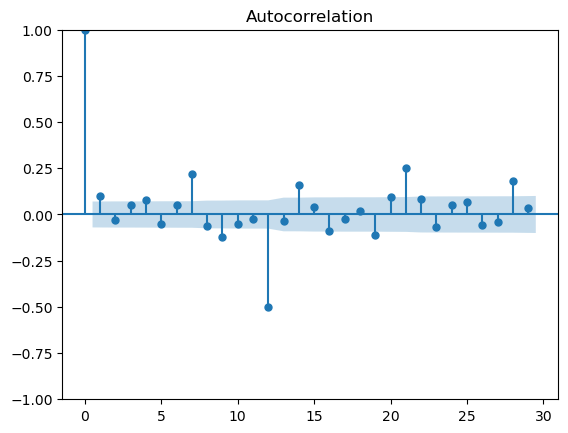

In [62]:
plot_acf(ts_plot_data.diff(12).dropna())
plt.show()

### dif = 7

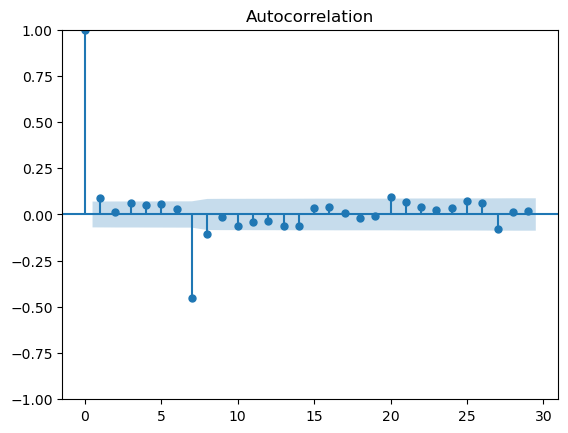

In [63]:
plot_acf(ts_plot_data.diff(7).dropna())
plt.show()

## Different models
- ARIMA(1,1,1)
- ARIMA(2,1,1)
- ARIMA(1,1,0)

In [64]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

### ARIMA(1,1,1)

In [65]:
model = ARIMA(x_train_ts, order=(1,1,1), freq='D')
model_fit = model.fit()

preds = model_fit.forecast(len(x_test_ts))


/home/matthew/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
best_ts = error_metrics(x_test_ts['bookings'], preds, 'ARIMA(1,1,1)')
best_ts

,model,rmse,mape,wmape
0,"ARIMA(1,1,1)",45.708066,0.198081,0.191471


Best Time Series Model
- RMSE: 45.71
- MAPE: 0.198
- WMAPE: 0.191

### ARIMA(2,1,1)

In [67]:
model = ARIMA(x_train_ts, order=(2,1,1), freq='D')
model_fit = model.fit()

preds = model_fit.forecast(len(x_test_ts))

error_metrics(x_test_ts['bookings'], preds, 'ARIMA(2,1,1)')


/home/matthew/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,model,rmse,mape,wmape
0,"ARIMA(2,1,1)",45.684273,0.200009,0.192221


### ARIMA(1,1,0)

In [68]:
model = ARIMA(x_train_ts, order=(1,1,0), freq='D')
model_fit = model.fit()

preds = model_fit.forecast(len(x_test_ts))

error_metrics(x_test_ts['bookings'], preds, 'ARIMA(1,1,0)')


/home/matthew/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,model,rmse,mape,wmape
0,"ARIMA(1,1,0)",53.821441,0.286703,0.249908


# Evaluating Models

In [69]:
model_metrics = pd.concat([lm_holiday, lasso_holiday, rf_holiday, gb_holiday, best_ts]).reset_index(drop=True) #ada_holiday
model_metrics.sort_values(by = 'mape')

,model,rmse,mape,wmape
1,lasso (holiday control),38.221321,0.183621,0.186010
0,simple linear (Holiday control),38.726962,0.192049,0.188276
3,Gradient Boosting (holiday control),40.934028,0.196886,0.193587
4,"ARIMA(1,1,1)",45.708066,0.198081,0.191471
2,Random Forest (Holiday control),41.989164,0.201463,0.205257


## Model Graphs

RMSE

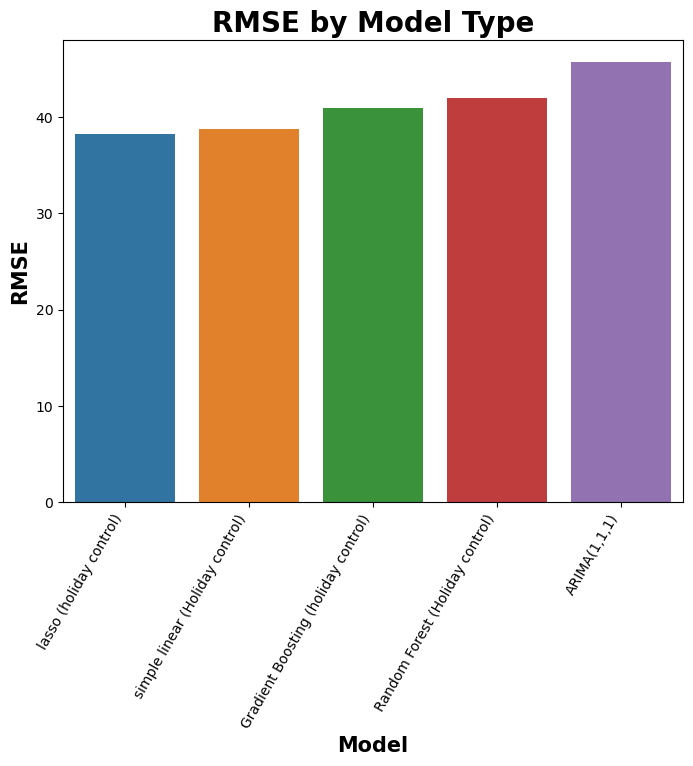

In [70]:
plt.figure(figsize=(8,6))
sns.barplot(data = model_metrics.sort_values(by= 'rmse', ascending= True), x = 'model', y = 'rmse', hue = 'model')
plt.title('RMSE by Model Type', fontdict = {'fontweight':'bold', 'fontsize': 20})


# X axis
plt.xlabel(xlabel= 'Model',fontdict = {'fontweight':'bold', 'fontsize': 15})
plt.xticks(rotation = 60, ha = 'right', fontweight = 'normal') # Rotate x tick labels to make plot more readable
# Y axis
plt.ylabel(ylabel= 'RMSE', fontdict ={'fontweight': 'bold', 'fontsize': 15})
plt.show() # THis hides x tick labels from printing 

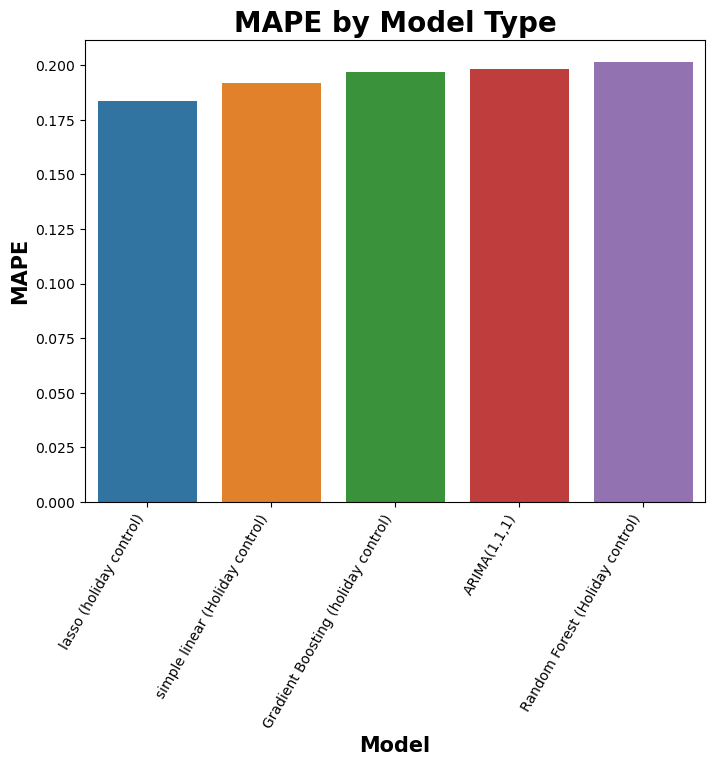

In [71]:
plt.figure(figsize=(8,6))
sns.barplot(data = model_metrics.sort_values(by= 'mape', ascending= True), x = 'model', y = 'mape', hue = 'model')
plt.title('MAPE by Model Type', fontdict = {'fontweight':'bold', 'fontsize': 20})


# X axis
plt.xlabel(xlabel= 'Model',fontdict = {'fontweight':'bold', 'fontsize': 15})
plt.xticks(rotation = 60, ha = 'right', fontweight = 'normal') # Rotate x tick labels to make plot more readable
# Y axis
plt.ylabel(ylabel= 'MAPE', fontdict ={'fontweight': 'bold', 'fontsize': 15})
plt.show() # THis hides x tick labels from printing 

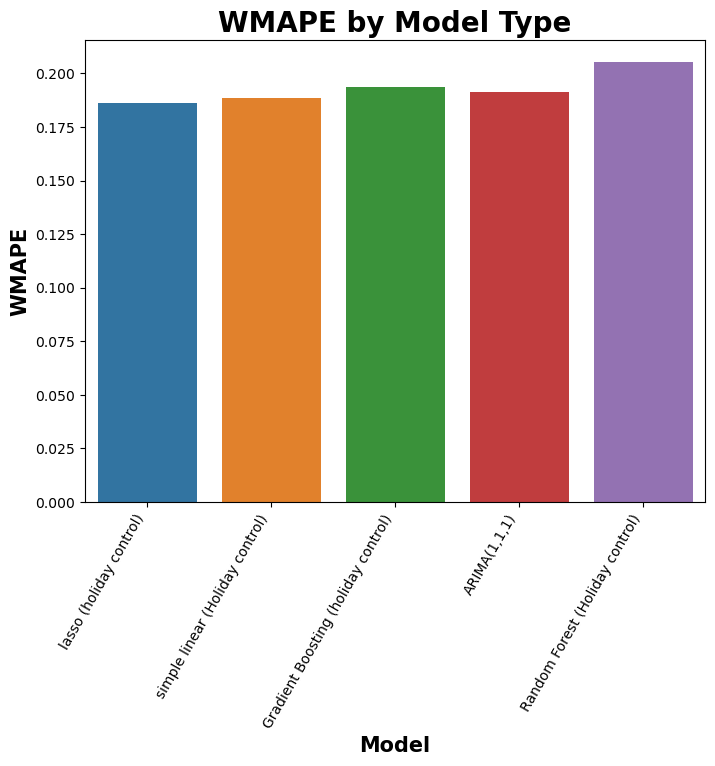

In [72]:
plt.figure(figsize=(8,6))
sns.barplot(data = model_metrics.sort_values(by= 'mape', ascending= True), x = 'model', y = 'wmape', hue = 'model')
plt.title('WMAPE by Model Type', fontdict = {'fontweight':'bold', 'fontsize': 20})


# X axis
plt.xlabel(xlabel= 'Model',fontdict = {'fontweight':'bold', 'fontsize': 15})
plt.xticks(rotation = 60, ha = 'right', fontweight = 'normal') # Rotate x tick labels to make plot more readable
# Y axis
plt.ylabel(ylabel= 'WMAPE', fontdict ={'fontweight': 'bold', 'fontsize': 15})
plt.show() # THis hides x tick labels from printing 